# Imports

In [170]:
import torch
import pandas as pd
import torch.optim as optim
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
# import operator
# from datetime import datetime
from utils import *
from models.rnn import *

In [152]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define CUDA

In [153]:
device = 'mps' if torch.cuda.is_available() else 'cpu'

# Load Dataset

In [154]:
#stocks dataset for Altaba Inc
dataset = pd.read_csv('data/bitcoin_final.csv')
dataset['date'] = dataset['date'].apply(lambda x: string_to_time(x))
display(dataset)

,date,price,13.tweets_neg,1.gt_bitcoin,10.news_senti,12.tweets_pos,14.twitter_btccrash_pos,2.gt_Buy_Bitcoin,7.s&p_twitter,8.CBDC_uncertainty,15.twitter_btccrash_neg,6.gt_covid,5.gt_Ukraine_war,9.CBDC_atten,3.gt_Sell_Bitcoin,4.gt_ethereum,11.fear&greed
0,1.519880e+09,10929.765497,0.043355,29.428571,0.179275,0.151006,0.215653,19.000000,99.350000,100.940928,0.130917,0.0,0.000000,100.431902,16.000000,12.428571,38.0
1,1.519967e+09,11095.091956,0.065677,29.285714,0.162121,0.133858,0.185810,19.000000,99.950000,101.036708,0.146667,0.0,0.000000,100.464187,16.000000,12.285714,47.0
2,1.520053e+09,11494.898944,0.050288,29.142857,0.146234,0.138788,0.136385,19.000000,100.296667,101.023647,0.202692,0.0,0.000000,100.439308,16.000000,12.142857,56.0
3,1.520140e+09,11516.383566,0.055335,29.000000,0.134706,0.147588,0.162947,19.000000,100.643333,101.010586,0.201579,0.0,0.000000,100.414430,16.000000,12.000000,44.0
4,1.520226e+09,11527.568787,0.045240,29.571429,0.124035,0.133230,0.126600,18.857143,100.990000,100.997525,0.172333,0.0,0.000000,100.389551,16.000000,11.857143,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,1.672031e+09,16908.948430,0.047236,17.714286,-0.100316,0.103354,0.126526,44.000000,154.027500,102.765109,0.188474,11.0,11.857143,101.536812,9.428571,4.571429,28.0
1762,1.672117e+09,16706.459710,0.051911,17.428571,-0.099167,0.121210,0.090167,43.000000,154.050000,102.691097,0.250583,11.0,11.714286,101.472052,9.857143,5.142857,27.0
1763,1.672204e+09,16549.983266,0.053312,17.142857,-0.088863,0.105740,0.084077,42.000000,152.360000,102.617084,0.275923,11.0,11.571429,101.407292,10.285714,5.714286,28.0
1764,1.672290e+09,16641.444864,0.050335,16.857143,-0.083155,0.123247,0.103692,41.000000,154.400000,102.543072,0.245385,11.0,11.428571,101.342532,10.714286,6.285714,28.0


# correlation 
not that important
1. 7.s&p_twitter	
2. price

In [155]:
dataset.corr()

,date,price,13.tweets_neg,1.gt_bitcoin,10.news_senti,12.tweets_pos,14.twitter_btccrash_pos,2.gt_Buy_Bitcoin,7.s&p_twitter,8.CBDC_uncertainty,15.twitter_btccrash_neg,6.gt_covid,5.gt_Ukraine_war,9.CBDC_atten,3.gt_Sell_Bitcoin,4.gt_ethereum,11.fear&greed
date,1.000000,0.662090,-0.057293,0.428256,-0.117907,0.376238,0.076397,0.415213,0.882238,0.732807,-0.054231,0.489799,0.464504,0.681081,0.325558,0.448147,-0.028576
price,0.662090,1.000000,-0.154895,0.728193,0.254453,0.464352,0.077945,0.614109,0.875708,0.746544,-0.026741,0.570111,0.213496,0.863508,0.644869,0.802576,0.242092
13.tweets_neg,-0.057293,-0.154895,1.000000,0.038828,-0.064618,-0.254964,-0.002978,-0.012444,-0.142661,-0.066024,0.031823,-0.051505,-0.012627,-0.094742,-0.014830,-0.056803,-0.211741
1.gt_bitcoin,0.428256,0.728193,0.038828,1.000000,0.235529,0.271627,0.030934,0.865095,0.579529,0.552772,0.044912,0.501815,0.069227,0.570238,0.916268,0.799180,0.297948
10.news_senti,-0.117907,0.254453,-0.064618,0.235529,1.000000,0.048276,0.095603,0.073286,0.126233,0.198463,-0.004494,-0.253486,-0.051869,0.291894,0.139995,0.323088,0.029979
12.tweets_pos,0.376238,0.464352,-0.254964,0.271627,0.048276,1.000000,0.030566,0.218197,0.489652,0.319730,0.004754,0.371057,0.079416,0.393474,0.244581,0.288573,0.142623
14.twitter_btccrash_pos,0.076397,0.077945,-0.002978,0.030934,0.095603,0.030566,1.000000,-0.013103,0.084723,0.081536,-0.331728,0.008006,0.122146,0.090262,0.011205,0.053959,-0.056213
2.gt_Buy_Bitcoin,0.415213,0.614109,-0.012444,0.865095,0.073286,0.218197,-0.013103,1.000000,0.510085,0.392228,0.060652,0.546819,0.013169,0.398940,0.931735,0.697615,0.441259
7.s&p_twitter,0.882238,0.875708,-0.142661,0.579529,0.126233,0.489652,0.084723,0.510085,1.000000,0.785257,-0.037768,0.591014,0.332565,0.836014,0.482528,0.649274,0.123894
8.CBDC_uncertainty,0.732807,0.746544,-0.066024,0.552772,0.198463,0.319730,0.081536,0.392228,0.785257,1.000000,-0.020975,0.272333,0.462582,0.911080,0.374541,0.654814,-0.098945


In [156]:
dataset['7.s&p_twitter'].describe()

count    1766.000000
mean      131.832197
std        26.504969
min        87.930000
25%       106.482500
50%       128.770000
75%       155.565000
max       180.180000
Name: 7.s&p_twitter, dtype: float64

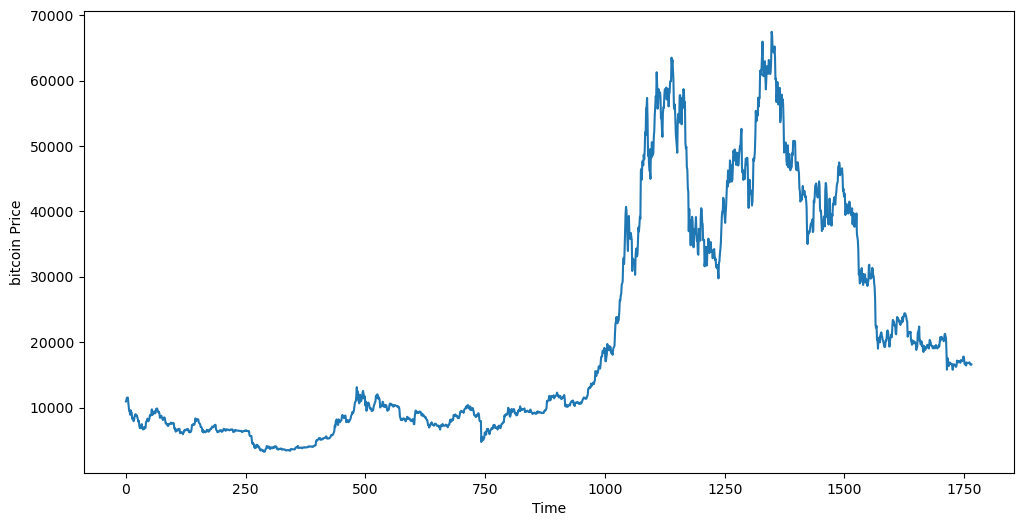

In [157]:
#close value is stock price at the end of that day
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(dataset))), dataset['price'])
plt.xlabel('Time')
plt.ylabel('bitcoin Price')
plt.show()

# Proprocess Dataset

In [158]:
#normalize dataset and keep track of close value
def up_down(x):
    if up_down.prev == None:
        up_down.prev = x
        return None
    else:
        if x > up_down.prev:
            up_down.prev = x
            return 1
        else:
            up_down.prev = x
            return 0
up_down.prev = None   
dataset['up_down'] = dataset['price'].apply(lambda x: up_down(x)) # up 1 down 0
dataset = dataset.replace(to_replace='None', value=np.nan).dropna()
dataset = dataset.drop(columns=['7.s&p_twitter', 'price'])
display(dataset)
print(dataset['up_down'].unique())

dataset['up_down'].describe()

,date,13.tweets_neg,1.gt_bitcoin,10.news_senti,12.tweets_pos,14.twitter_btccrash_pos,2.gt_Buy_Bitcoin,8.CBDC_uncertainty,15.twitter_btccrash_neg,6.gt_covid,5.gt_Ukraine_war,9.CBDC_atten,3.gt_Sell_Bitcoin,4.gt_ethereum,11.fear&greed,up_down
1,1.519967e+09,0.065677,29.285714,0.162121,0.133858,0.185810,19.000000,101.036708,0.146667,0.0,0.000000,100.464187,16.000000,12.285714,47.0,1.0
2,1.520053e+09,0.050288,29.142857,0.146234,0.138788,0.136385,19.000000,101.023647,0.202692,0.0,0.000000,100.439308,16.000000,12.142857,56.0,1.0
3,1.520140e+09,0.055335,29.000000,0.134706,0.147588,0.162947,19.000000,101.010586,0.201579,0.0,0.000000,100.414430,16.000000,12.000000,44.0,1.0
4,1.520226e+09,0.045240,29.571429,0.124035,0.133230,0.126600,18.857143,100.997525,0.172333,0.0,0.000000,100.389551,16.000000,11.857143,55.0,1.0
5,1.520312e+09,0.054801,30.142857,0.117684,0.104650,0.138111,18.714286,100.984464,0.235667,0.0,0.000000,100.364673,16.000000,11.714286,59.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,1.672031e+09,0.047236,17.714286,-0.100316,0.103354,0.126526,44.000000,102.765109,0.188474,11.0,11.857143,101.536812,9.428571,4.571429,28.0,1.0
1762,1.672117e+09,0.051911,17.428571,-0.099167,0.121210,0.090167,43.000000,102.691097,0.250583,11.0,11.714286,101.472052,9.857143,5.142857,27.0,0.0
1763,1.672204e+09,0.053312,17.142857,-0.088863,0.105740,0.084077,42.000000,102.617084,0.275923,11.0,11.571429,101.407292,10.285714,5.714286,28.0,0.0
1764,1.672290e+09,0.050335,16.857143,-0.083155,0.123247,0.103692,41.000000,102.543072,0.245385,11.0,11.428571,101.342532,10.714286,6.285714,28.0,1.0


[1. 0.]


count    1765.000000
mean        0.518414
std         0.499802
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: up_down, dtype: float64

In [159]:
#split data into training and testing components
from utils import *
x_train, y_train, x_test, y_test = split_data(dataset, 10)
# should be balance 
white_train = len(y_train[y_train==1])
black_train = len(y_train[y_train==0])
train_imbalance = 1 if white_train >black_train else 0
train_remove = max([white_train,black_train])-min([white_train,black_train])

white_test = len(y_test[y_test==1])
black_test = len(y_test[y_test==0])
test_imbalance = 1 if white_test >black_test else 0
test_remove = max([white_test,black_test])-min([white_test,black_test])

print('TRAIN :','1 :',white_train,'0 :',black_train,'imbalance :',train_remove)
print('TEST  :','1 :',white_test, '0 :',black_test, 'imbalance ', test_remove)

num = 0
if white_train == black_train:
    print('No imbalance in train dataset')
else:
    for i,el in enumerate(y_train):
        if num <= train_remove and el == train_imbalance:
                x_train = np.delete(x_train,i,axis=0)
                y_train = np.delete(y_train,i,axis=0)
                num+=1


num = 0

if white_test == black_test:
    print('No imbalance in test dataset')
else:
    for i,el in enumerate(y_test):
        if num <= test_remove and el == test_imbalance:
            x_test = np.delete(x_test,i,axis=0)
            y_test = np.delete(y_test,i,axis=0)
            num+=1


x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
# x_val = torch.from_numpy(x_train).float()
# y_val = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

TRAIN : 1 : 744 0 : 660 imbalance : 84
TEST  : 1 : 167 0 : 184 imbalance  17
torch.Size([1319, 9, 16])
torch.Size([1319])
torch.Size([333, 9, 16])
torch.Size([333])


# Initialize Hyperparameters

In [163]:
input_size = 16
hidden_dim = 10
num_layers = 3
output_dim = 1
epochs = 200

# Define Model (GRU)

In [172]:
model = Conv(input_size, hidden_dim, num_layers, output_dim).to(device)
loss_func = nn.BCELoss(reduction="mean").to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train Model

In [173]:
train_loss = []
# min_loss = np.Inf
max_acc = 0
for epoch in range(epochs):
    #zero out gradients
    optimizer.zero_grad()
    pred = model(x_train.to(device)).squeeze()
    loss = loss_func(pred, y_train.to(device))
    train_loss.append(loss.item())
    # print('Epoch {}, Loss: {:.10f}\n'.format(epoch, loss.item()))
    model.eval()
    pred = model(x_test.to(device)).squeeze()
    val_loss = loss_func(pred, y_test.to(device)).item()
    acc = get_accuracy(pred,y_test.to(device))
    if acc > max_acc:
        print('     train: {:.10f}  acc: {:.4f} val Loss: {:.10f}\n'.format(train_loss[-1],acc,val_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        max_acc = acc
    model.train()
    #back propogate
    loss.backward()
    optimizer.step()


RuntimeError: Given groups=1, weight of size [5, 16, 16, 32], expected input[1, 1319, 9, 16] to have 16 channels, but got 1319 channels instead

# Evaluating Model

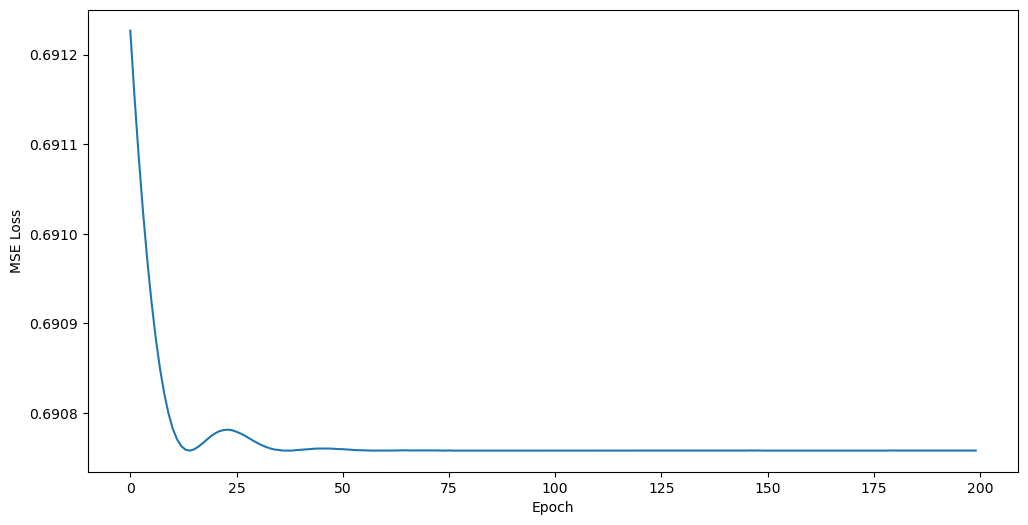

In [147]:
#visualize loss throughout training
plt.figure(figsize=(12, 6))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.plot(list(range(epochs)), train_loss)

# Load the Best Model

In [142]:
best_model = LSTM(input_size, hidden_dim, num_layers, output_dim).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [143]:
#get predictions
pred = model(x_test.to(device)).squeeze()
test_loss = loss_func(pred.squeeze(), y_test.to(device))
print(get_accuracy(pred,y_test.to(device)),test_loss.item())

0.48656716417910445 0.695892870426178


# Visualizing and Testing Model

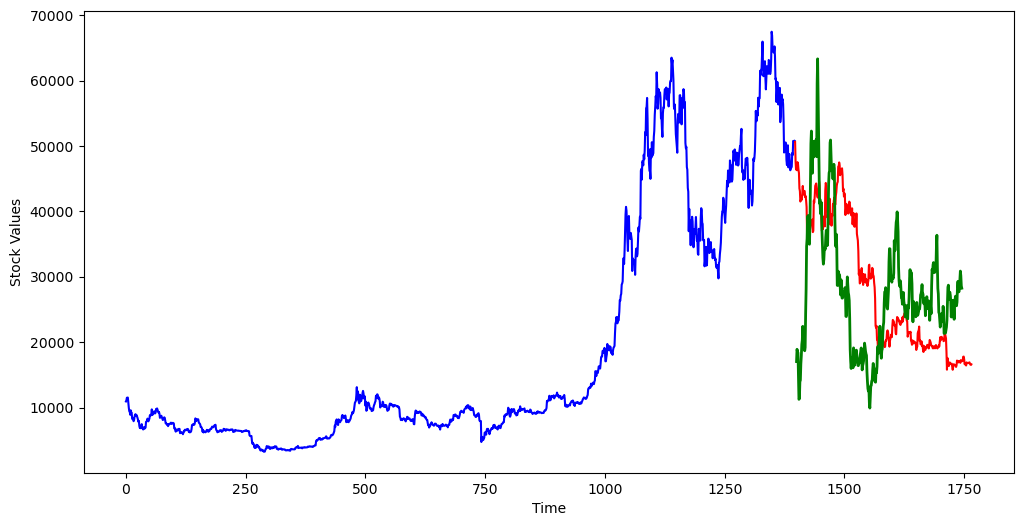

In [243]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(x_train.size(0))], bit_value[:x_train.size(0)], color='b', label='trained values')

#plot test range and predictions by the GRU
time_values_actual = list(range(x_train.size(0), len(bit_value)))
time_values_pred = list(range(x_train.size(0), x_train.size(0) + y_test.size(0)))
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.plot(time_values_actual, bit_value[-len(time_values_actual):], color='r', label='actual values')
plt.plot(time_values_pred[3:], lstm_predictions[3:], color='g', linewidth=2, label='predicted values')

plt.show()